**Построение рекомендательной системы на основе графового эмбеддинга.**

In [ ]:
!pip install node2vec

In [ ]:
import time
import sqlite3
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
conn = sqlite3.connect('okved_20230329.sqlite3')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
[table[0] for table in tables]

['natural_person',
 'supplier',
 'okved',
 'legal_entity',
 'product',
 'company_to_okved',
 'company_to_natural_member',
 'company_to_legal_member',
 'procurement']

In [ ]:
tables = ["product", "supplier"]

In [ ]:
dict_of_tables_to_columns = {}
for table in tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    dict_of_tables_to_columns[table] = [column[1] for column in columns]

In [ ]:
for k,v in dict_of_tables_to_columns.items():
    print('\033[1m' + k + '\033[0m')
    print(v)
    print()

product
['id', 'name', 'price', 'presence', 'is_popular', 'info', 'tags', 'url', 'supplier_id']

supplier
['id', 'name', 'address', 'url', 'inn']



In [ ]:
G = nx.Graph()

for table,columns in dict_of_tables_to_columns.items():
    cursor.execute(f"SELECT * FROM {table}")
    table_data = cursor.fetchall()

    if table == 'product':
        table_data = table_data

    print(table, len(table_data))
    for i, row in enumerate(table_data):
        node_attributes = {attr: row[j] for j, attr in enumerate(columns)}
        node_attributes['type'] = table
        node_name = f"{table}_{i}"

        G.add_node(node_name, **node_attributes)
len(G)

product 157068
supplier 3134


160202

## Cвязываю узлы на основе данных из атрибутов узлов

In [ ]:
%%time

product_to_supplier_id = {data['supplier_id']: node for node, data in G.nodes(data=True) if data.get('type') == 'product'}
supplier_to_id = {data['id']: node for node, data in G.nodes(data=True) if data.get('type') == 'supplier'}
for supplier_id, product in product_to_supplier_id.items():
    if supplier_id in supplier_to_id:
        G.add_edge(product, supplier_to_id[supplier_id])

Wall time: 518 ms


In [ ]:
len(G.edges())

3134

In [ ]:
supplier_to_inn = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'supplier'}

for inn, node in supplier_to_inn.items():
    suppliers_with_same_inn = [n for n, d in G.nodes(data=True) if d.get('type') == 'supplier' and d.get('inn') == inn]
    for supplier_node in suppliers_with_same_inn:
        if supplier_node != node:
            G.add_edge(node, supplier_node)

In [ ]:
len(list(nx.isolates(G)))

153934

In [ ]:
G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
len(G)

6268

In [ ]:
cursor.close()
conn.close()

In [ ]:
nx.write_gpickle(G, "graph.pkl")

In [ ]:
G = nx.read_gpickle("graph.pkl")
len(G)

6268

In [ ]:
typee=[]
for node, data in G.nodes(data=True):
    if data['type']=='product' and data['type'] not in typee:
        typee.append(data['type'])
        print(node, data)
        print()
    elif data['type']=='supplier' and data['type'] not in typee:
        typee.append(data['type'])
        print(node, data)
        print()

product_7 {'id': 49, 'name': 'Защитные экраны для кондиционеров (Дефлекторы)', 'price': '3 150 руб.', 'presence': 'Наличие не указано', 'is_popular': 0, 'info': 'Кондиционер дует прямо на вас\nМы знаем как это исправить\nЗащитные экраны для кондиционеров предназначены для того, чтобы перенаправлять холодный воздух от человека вдоль потолка так, чтобы он плавно опускался по всей площади и предотвращал переохлаждение и простуду', 'tags': 'Товары и услуги/Оборудование и инструменты/Климатическое оборудование', 'url': 'https://supl.biz/zaschitnyie-ekranyi-dlya-konditsionerov-deflektory-p49/', 'supplier_id': '582425', 'type': 'product'}

supplier_0 {'id': '436479', 'name': 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "БОМБАЛЮКС"', 'address': 'Москва, 109431, г. Москва, ул. Привольная, д. 65, корп.3, кв. 54', 'url': 'https://supl.biz/profiles/436479/', 'inn': None, 'type': 'supplier'}



## Векторизация

In [ ]:
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
type_counts = {}
for node, node_type in node_types.items():
    type_counts[node_type] = type_counts.get(node_type, 0) + 1

for node_type, count in type_counts.items():
    print(f"Тип {node_type}: {count/len(G)}")

Тип product: 0.5
Тип supplier: 0.5


In [ ]:
node2vec = Node2Vec(G, dimensions=32, walk_length=10, p=1, q=2)
model = node2vec.fit(window=6)

Computing transition probabilities:   0%|          | 0/6268 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.42s/it]


In [ ]:
embeddings = model.wv.vectors

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

index_to_pos = {i: embeddings_pca[model.wv.index_to_key.index(i)] for i in model.wv.index_to_key}
nx.set_node_attributes(G, index_to_pos, 'pos')
pos = nx.get_node_attributes(G, 'pos')

In [ ]:
embeddings.shape

(6268, 32)

In [ ]:
node_colors = {
    'product': 'blue',
    'supplier': 'green'
}
colors = [node_colors[G.nodes[node]['type']] for node in G.nodes()]

100%|█████████████████████████████████████████████████████████████████████████████| 6267/6267 [00:07<00:00, 788.29it/s]


<Figure size 1800x1800 with 0 Axes>

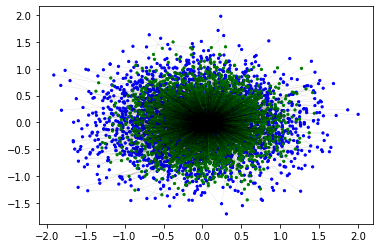

Wall time: 15.5 s


In [ ]:
%%time
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.figure(figsize=(25,25))

x_values, y_values = zip(*pos.values())
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, color=colors, s=5)
for edge in tqdm(G.edges()):
    node1 = edge[0]
    node2 = edge[1]
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    ax.plot([x1, x2], [y1, y2], 'k-', lw=0.05)

plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 15490/15490 [00:19<00:00, 794.78it/s]


<Figure size 1800x1800 with 0 Axes>

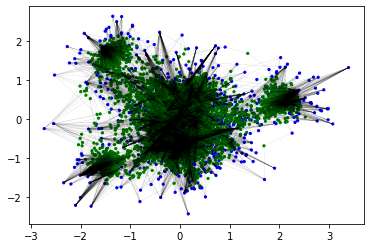

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.figure(figsize=(25,25))
x_values, y_values = zip(*pos.values())
fig, ax = plt.subplots()
ax.scatter(x_values, y_values, color=colors, s=5)

for edge in tqdm(G.edges()):
    node1 = edge[0]
    node2 = edge[1]
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    ax.plot([x1, x2], [y1, y2], 'k-', lw=0.05)

plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 15490/15490 [00:21<00:00, 706.27it/s]


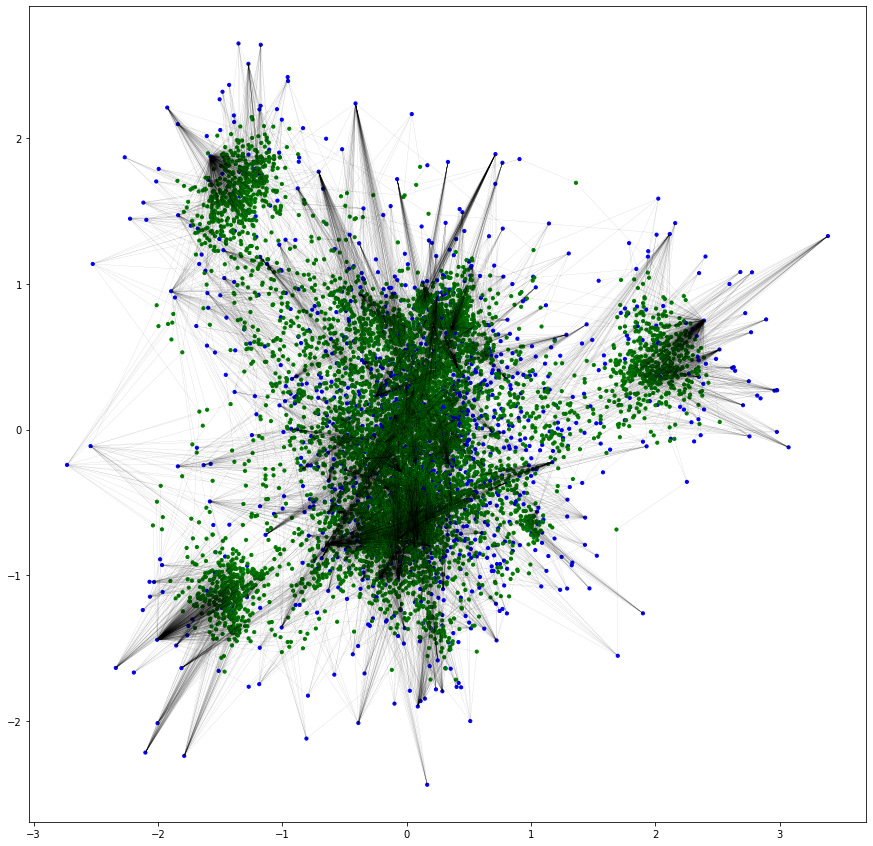

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.figure(figsize=(15, 15))

for edge in tqdm(G.edges()):
    node1 = edge[0]
    node2 = edge[1]
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    plt.plot([x1, x2], [y1, y2], 'k-', lw=0.05)

x_values, y_values = zip(*pos.values())
plt.scatter(x_values, y_values, color=colors, s=10)

plt.show()

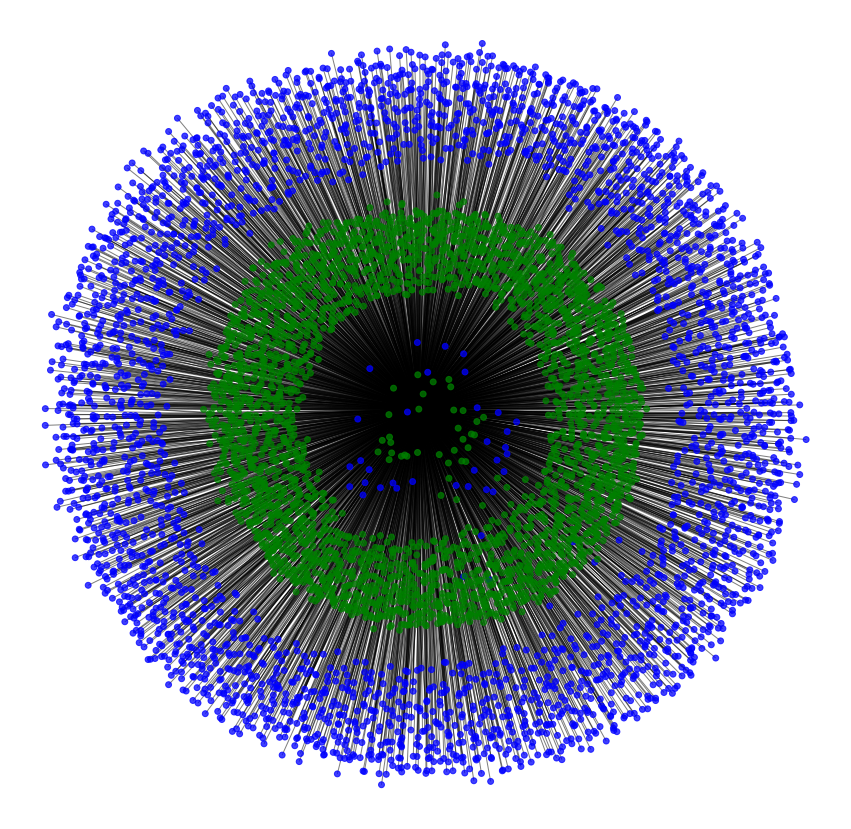

Wall time: 9min 30s


In [ ]:
%%time
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=35, node_color = colors, alpha=0.75)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis("off")
plt.show()

In [ ]:
all_nodes = list(G.nodes())
train_nodes, test_nodes = train_test_split(all_nodes, test_size=0.2, random_state=42)
G_train = G.subgraph(train_nodes)
G_test = G.subgraph(test_nodes)
embeddings_train = {node: embeddings[model.wv.index_to_key.index(node)] for node in G_train.nodes() if node in model.wv.index_to_key}
embeddings_test = {node: embeddings[model.wv.index_to_key.index(node)] for node in G_test.nodes() if node in model.wv.index_to_key}

missing_train_embeddings = [node for node in G_train.nodes() if node not in embeddings_train]
missing_test_embeddings = [node for node in G_test.nodes() if node not in embeddings_test]

print("Missing embeddings in train set:", missing_train_embeddings)
print("Missing embeddings in test set:", missing_test_embeddings)

Missing embeddings in train set: []
Missing embeddings in test set: []


In [ ]:
def recommend_products_for_supplier_cosine_similarity(G, embeddings, supplier_node):
    supplier_embedding = embeddings[supplier_node]
    product_nodes = [node for node in G.nodes() if G.nodes[node]['type'] == 'product']
    product_embeddings = [embeddings[node] for node in product_nodes]

    similarities = cosine_similarity([supplier_embedding], product_embeddings)[0]
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)

    recommended_products = [product_nodes[i] for i in sorted_indices[:5]]  # Возьмем топ-5 наиболее похожих продуктов

    return recommended_products

In [ ]:
supplier_node = "supplier_16"
if supplier_node in embeddings_train:
    recommendations_for_supplier = recommend_products_for_supplier_cosine_similarity(G_train, embeddings_train, supplier_node)
    print("Рекомендации для поставщика", supplier_node, ":", recommendations_for_supplier)
else:
    print("Supplier node not found in embeddings.")

Рекомендации для поставщика supplier_16 : ['product_25431', 'product_91677', 'product_149696', 'product_63360', 'product_4668']


In [1]:
def evaluate_recommendations(actual_purchases, recommended_products):
    precision_scores = []
    for supplier_node, actual_products in actual_purchases.items():
        if supplier_node not in recommended_products:
            continue
        recommended = recommended_products[supplier_node]
        if not recommended:
            continue
        actual_set = set(actual_products)
        recommended_set = set(recommended)
        true_positives = actual_set & recommended_set
        precision = len(true_positives) / len(recommended_set) if recommended_set else 0
        precision_scores.append(precision)
    avg_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    return avg_precision

In [2]:
actual_purchases = {}
for supplier_node in G_test.nodes():
    actual_purchases[supplier_node] = [node for node in G_test.neighbors(supplier_node) if G_test.nodes[node]['type'] == 'product' and node in embeddings_test]

recommendations = {}
for supplier_node in G_test.nodes():
    if supplier_node in embeddings_train:
        recommendations[supplier_node] = recommend_products_for_supplier_cosine_similarity(G_train, embeddings_train, supplier_node)

# Оценка рекомендаций
avg_precision = evaluate_recommendations(actual_purchases, recommendations)
print("Средняя точность: {:.2f}".format(avg_precision))

Средняя точность: 0.41
